### Integrantes:
#### Bryan Cunduri
#### Elisa Herrera
#### Mayra Pachacama
#### Grupo 3

# Long Short-Term Memory (LSTM)

Shortly after the first Elman-style RNNs were trained using backpropagation (Elman, 1990), the problems of learning long-term dependencies (owing to vanishing and exploding gradients) became salient, with Bengio and Hochreiter discussing the problem (Bengio et al., 1994, Hochreiter et al., 2001). Hochreiter had articulated this problem as early as 1991 in his Master’s thesis, although the results were not widely known because the thesis was written in German. While gradient clipping helps with exploding gradients, handling vanishing gradients appears to require a more elaborate solution. One of the first and most successful techniques for addressing vanishing gradients came in the form of the long short-term memory (LSTM) model due to Hochreiter and Schmidhuber (1997). LSTMs resemble standard recurrent neural networks but here each ordinary recurrent node is replaced by a memory cell. Each memory cell contains an internal state, i.e., a node with a self-connected recurrent edge of fixed weight 1, ensuring that the gradient can pass across many time steps without vanishing or exploding.

The term “long short-term memory” comes from the following intuition. Simple recurrent neural networks have long-term memory in the form of weights. The weights change slowly during training, encoding general knowledge about the data. They also have short-term memory in the form of ephemeral activations, which pass from each node to successive nodes. The LSTM model introduces an intermediate type of storage via the memory cell. A memory cell is a composite unit, built from simpler nodes in a specific connectivity pattern, with the novel inclusion of multiplicative nodes.

In [1]:
use strict; 
use warnings; 
use Data::Dump qw(dump); 
use AI::MXNet qw(mx);
use d2l;
IPerl->load_plugin('Chart::Plotly');


### 10.1.1. Gated Memory Cell
Each memory cell is equipped with an internal state and a number of multiplicative gates that determine whether (i) a given input should impact the internal state (the input gate), (ii) the internal state should be flushed to 
 (the forget gate), and (iii) the internal state of a given neuron should be allowed to impact the cell’s output (the output gate).

#### 10.1.1.1. Gated Hidden State
The key distinction between vanilla RNNs and LSTMs is that the latter support gating of the hidden state. This means that we have dedicated mechanisms for when a hidden state should be updated and also for when it should be reset. These mechanisms are learned and they address the concerns listed above. For instance, if the first token is of great importance we will learn not to update the hidden state after the first observation. Likewise, we will learn to skip irrelevant temporary observations. Last, we will learn to reset the latent state whenever needed. We discuss this in detail below

#### 10.1.1.2. Input Gate, Forget Gate, and Output Gate
The data feeding into the LSTM gates are the input at the current time step and the hidden state of the previous time step, as illustrated in Fig. 10.1.1. Three fully connected layers with sigmoid activation functions compute the values of the input, forget, and output gates. As a result of the sigmoid activation, all values of the three gates are in the range of 
. Additionally, we require an input node, typically computed with a tanh activation function. Intuitively, the input gate determines how much of the input node’s value should be added to the current memory cell internal state. The forget gate determines whether to keep the current value of the memory or flush it. And the output gate determines whether the memory cell should influence the output at the current time step.

Mathematically, suppose that there are 
 hidden units, the batch size is 
, and the number of inputs is 
. Thus, the input is 
 and the hidden state of the previous time step is 
. Correspondingly, the gates at time step 
 are defined as follows: the input gate is 
, the forget gate is 
, and the output gate is 
. They are calculated as follows:

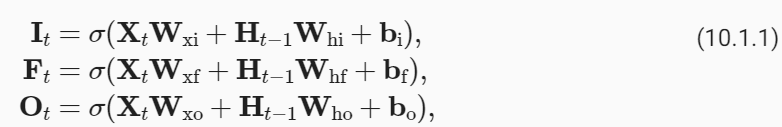

where 
 and 
 are weight parameters and 
 are bias parameters. Note that broadcasting (see Section 2.1.4) is triggered during the summation. We use sigmoid functions (as introduced in Section 5.1) to map the input values to the interval 
.

#### 10.1.1.3. Input Node
Next we design the memory cell. Since we have not specified the action of the various gates yet, we first introduce the input node 
. Its computation is similar to that of the three gates described above, but uses a 
 function with a value range for 
 as the activation function. This leads to the following equation at time step 
:

(10.1.2)
where 
 and 
 are weight parameters and 
 is a bias parameter.

A quick illustration of the input node is shown in Fig. 10.1.2.

#### 10.1.1.4. Memory Cell Internal State
In LSTMs, the input gate 
 governs how much we take new data into account via 
 and the forget gate 
 addresses how much of the old cell internal state 
 we retain. Using the Hadamard (elementwise) product operator 
 we arrive at the following update equation:

(10.1.3)
If the forget gate is always 1 and the input gate is always 0, the memory cell internal state 
 will remain constant forever, passing unchanged to each subsequent time step. However, input gates and forget gates give the model the flexibility of being able to learn when to keep this value unchanged and when to perturb it in response to subsequent inputs. In practice, this design alleviates the vanishing gradient problem, resulting in models that are much easier to train, especially when facing datasets with long sequence lengths.

We thus arrive at the flow diagram in Fig. 10.1.3.

#### 10.1.1.5. Hidden State
Last, we need to define how to compute the output of the memory cell, i.e., the hidden state 
, as seen by other layers. This is where the output gate comes into play. In LSTMs, we first apply 
 to the memory cell internal state and then apply another point-wise multiplication, this time with the output gate. This ensures that the values of 
 are always in the interval 
:

(10.1.4)
Whenever the output gate is close to 1, we allow the memory cell internal state to impact the subsequent layers uninhibited, whereas for output gate values close to 0, we prevent the current memory from impacting other layers of the network at the current time step. Note that a memory cell can accrue information across many time steps without impacting the rest of the network (as long as the output gate takes values close to 0), and then suddenly impact the network at a subsequent time step as soon as the output gate flips from values close to 0 to values close to 1. Fig. 10.1.4 has a graphical illustration of the data flow.

In [2]:
package LSTMScratch{ # Define lSTMScratch package
use base qw(d2l::Module); 
  sub new {
      (my $class, our %args) = (shift, d2l->get_arguments
                                  (num_inputs  => 0, # alimentamos con valores por defecto args
                                  num_hiddens => 0,
                                  sigma       => 0.01,
                                  \@_));

                          
      my $self = $class -> SUPER::new();# llamada al metodo constructor de la clase heredada
      $self->save_hyperparameters(%args);
      
    my $init_weight = sub { my @shape = @_;
                            our %args;
                            mx->nd->random->randn(@shape) * $args{sigma};};
    my $triple = sub{our %args;
                  $init_weight->($args{num_inputs},$args{num_hiddens}),
                  $init_weight->($args{num_hiddens},$args{num_hiddens}),
                  mx->nd->zeros([$args{num_hiddens}])};
                  
   ($self->{W_xi},$self->{W_hi},$self->{b_i}) = $triple->();
   ($self->{W_xf},$self->{W_hf},$self->{b_f}) = $triple->();
   ($self->{W_xo},$self->{W_ho},$self->{b_o}) = $triple->();
   ($self->{W_xc},$self->{W_hc},$self->{b_c}) = $triple->();

    return bless($self, $class);
}
1;
}


1

### 10.1.2. Implementation from Scratch
Now let’s implement an LSTM from scratch. As same as the experiments in Section 9.5, we first load The Time Machine dataset.

#### 10.1.2.1. Initializing Model Parameters
Next, we need to define and initialize the model parameters. As previously, the hyperparameter num_hiddens dictates the number of hidden units. We initialize weights following a Gaussian distribution with 0.01 standard deviation, and we set the biases to 0.

The actual model is defined as described above, consisting of three gates and an input node. Note that only the hidden state is passed to the output layer.

In [3]:
# Método forward
my $forward = sub {
    my ($self, %args) =(shift, d2l->get_arguments(inputs=>undef,
                                                 H_C=>undef, \@_)); 
 if (!defined $args{H_C}){
        $args{H} = mx->nd->zeros([$args{inputs}->shape->[1], $self->{num_hiddens}], ctx => $args{inputs}->context);
        $args{C} = mx->nd->zeros([$args{inputs}->shape->[1], $self->{num_hiddens}], ctx => $args{inputs}->context);
    }else{
        ($args{H}, $args{C}, undef) = @{$args{H_C}}; 
        
    }

    my ( $outputs, $I, $F, $O, $C_tilde, $H, $total) =[];
    

    foreach my $X (@{$args{inputs}}){ 
        $I = mx->nd->sigmoid(mx->nd->dot($X, $self->{W_xi}) +
                               mx->nd->dot($H, $self->{W_hi}) + $self->{b_i});
        $F = mx->nd->sigmoid(mx->nd->dot($X, $self->{W_xf}) +
                               mx->nd->dot($H, $self->{W_hf}) + $self->{b_f});
        $O =  mx->nd->sigmoid(mx->nd->dot($X, $self->{W_xo}) +
                               mx->nd->dot($H, $self->{W_ho}) + $self->{b_o});   
        $C_tilde= mx->nd->tanh(mx->nd->dot($X, $self->{W_xc}) +
                                  mx->nd->dot($H, $self->{W_hc}) + $self->{b_c});
                               
        $args{H_C} = $I + $F +  $O + $C_tilde;
        push @$outputs, $args{H_C};
    }
        

        $args{H_C} = $I * $F + $O * $C_tilde;
        $H = $O * mx->nd->tanh($args{H_C});

        push @$outputs, $args{H_C};
    
    return $outputs, $args{H_C};
 };
 
 d2l->add_to_class('LSTMScratch', 'forward', $forward);

*LSTMScratch::forward

#### 10.1.2.2. Training and Prediction
Let’s train an LSTM model by instantiating the RNNLMScratch class from Section 9.5.

In [10]:
# Crear objeto lstm
my $lstm = LSTM->new(num_inputs => $data->{vocab}->len, num_hiddens => 32);

# Crear objeto RNNLMScratch
my $model = d2l::RNNLM->new(lstm => $lstm, vocab_size => $data->{vocab}->len, lr => 4);

# Crear Trainer
my $trainer = d2l::Trainer->new(max_epochs => 50, gradient_clip_val => 1, num_gpus => 1);

$trainer->fit($model, $data);

Error: Can't locate object method "forward" via package "lstm" (perhaps you forgot to load "lstm"?) at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/d2l.pm line 7575.
 at /usr/local/lib/perl5/site_perl/5.32.1/AI/MXNet/AutoGrad.pm line 408.
	AI::MXNet::AutoGrad::record("AI::MXNet::AutoGrad", CODE(0xcf3ae38)) called at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/d2l.pm line 6945
	d2l::Trainer::fit_epoch(d2l::Trainer=HASH(0xbb57758)) called at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/d2l.pm line 6897
	d2l::Trainer::fit(d2l::Trainer=HASH(0xbb57758), d2l::RNNLM=HASH(0xc72a2b8), d2l::TimeMachine=HASH(0xc72a450)) called at reply input line 14
	Eval::Closure::Sandbox_1594::__ANON__() called at /usr/local/lib/perl5/site_perl/5.32.1/Reply/Plugin/Defaults.pm line 71
	Reply::Plugin::Defaults::execute(Reply::Plugin::Defaults=HASH(0x48c6000), CODE(0x4f56e20), CODE(0xd1265b8)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 217
	Reply::_wrapped_plugin(Reply=HASH(0x488dee8), ARRAY(0x4f56760), "execute", CODE(0xd1265b8)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 215
	Reply::__ANON__(CODE(0xd1265b8)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply/Plugin/IPerl.pm line 28
	Reply::Plugin::IPerl::__ANON__() called at /usr/local/lib/perl5/site_perl/5.32.1/Capture/Tiny.pm line 382
	eval {...} called at /usr/local/lib/perl5/site_perl/5.32.1/Capture/Tiny.pm line 382
	Capture::Tiny::_capture_tee(1, 1, 0, 0, CODE(0xd1589d0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply/Plugin/IPerl.pm line 29
	Reply::Plugin::IPerl::execute(Reply::Plugin::IPerl=HASH(0x48df958), CODE(0xc73f968), CODE(0xd1265b8)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 217
	Reply::_wrapped_plugin(Reply=HASH(0x488dee8), "execute", CODE(0xd1265b8)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 174
	Reply::_eval(Reply=HASH(0x488dee8), "\x{a}#line 1 \"reply input\"\x{a}# Crear objeto lstm\x{a}my \$lstm = LSTM->n"...) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 66
	Reply::try {...} () called at /usr/local/lib/perl5/site_perl/5.32.1/Try/Tiny.pm line 102
	eval {...} called at /usr/local/lib/perl5/site_perl/5.32.1/Try/Tiny.pm line 93
	Try::Tiny::try(CODE(0xd18bec8), Try::Tiny::Catch=REF(0xc4d8700)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 71
	Reply::step(Reply=HASH(0x488dee8), "# Crear objeto lstm\x{a}my \$lstm = LSTM->new(num_inputs => \$data-"..., 0) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel/Backend/Reply.pm line 48
	Devel::IPerl::Kernel::Backend::Reply::__ANON__() called at /usr/local/lib/perl5/site_perl/5.32.1/Capture/Tiny.pm line 382
	eval {...} called at /usr/local/lib/perl5/site_perl/5.32.1/Capture/Tiny.pm line 382
	Capture::Tiny::_capture_tee(1, 1, 0, 0, CODE(0x4939a00)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel/Backend/Reply.pm line 49
	Devel::IPerl::Kernel::Backend::Reply::run_line(Devel::IPerl::Kernel::Backend::Reply=HASH(0x1f1cd00), "# Crear objeto lstm\x{a}my \$lstm = LSTM->new(num_inputs => \$data-"...) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel/Callback/REPL.pm line 42
	Devel::IPerl::Kernel::Callback::REPL::execute(Devel::IPerl::Kernel::Callback::REPL=HASH(0x225fef0), Devel::IPerl::Kernel=HASH(0x23f97a0), Devel::IPerl::Message::ZMQ=HASH(0x4f47538)) called at (eval 30) line 6
	Devel::IPerl::Kernel::Callback::REPL::execute(Devel::IPerl::Kernel::Callback::REPL=HASH(0x225fef0), Devel::IPerl::Kernel=HASH(0x23f97a0), Devel::IPerl::Message::ZMQ=HASH(0x4f47538)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel/Callback/REPL.pm line 156
	Devel::IPerl::Kernel::Callback::REPL::msg_execute_request(Devel::IPerl::Kernel::Callback::REPL=HASH(0x225fef0), Devel::IPerl::Kernel=HASH(0x23f97a0), Devel::IPerl::Message::ZMQ=HASH(0x4f47538), ZMQ::LibZMQ3::Socket=HASH(0x4f33fb0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel.pm line 245
	Devel::IPerl::Kernel::route_message(Devel::IPerl::Kernel=HASH(0x23f97a0), ARRAY(0x4f340d0), ZMQ::LibZMQ3::Socket=HASH(0x4f33fb0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel.pm line 215
	Devel::IPerl::Kernel::__ANON__(Net::Async::ZMQ::Socket=HASH(0x4f34160)) called at /usr/local/lib/perl5/site_perl/5.32.1/IO/Async/Loop/Poll.pm line 172
	IO::Async::Loop::Poll::post_poll(IO::Async::Loop::Poll=HASH(0x4e36b18)) called at /usr/local/lib/perl5/site_perl/5.32.1/IO/Async/Loop/Poll.pm line 292
	IO::Async::Loop::Poll::loop_once(IO::Async::Loop::Poll=HASH(0x4e36b18), undef) called at /usr/local/lib/perl5/site_perl/5.32.1/IO/Async/Loop.pm line 538
	IO::Async::Loop::run(IO::Async::Loop::Poll=HASH(0x4e36b18)) called at /usr/local/lib/perl5/site_perl/5.32.1/IO/Async/Loop.pm line 575
	IO::Async::Loop::loop_forever(IO::Async::Loop::Poll=HASH(0x4e36b18)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel.pm line 225
	Devel::IPerl::Kernel::run(Devel::IPerl::Kernel=HASH(0x23f97a0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl.pm line 14
	Devel::IPerl::main() called at -e line 1


### 10.1.3. Concise Implementation
Using high-level APIs, we can directly instantiate an LSTM model. This encapsulates all the configuration details that we made explicit above. The code is significantly faster as it uses compiled operators rather than Python for many details that we spelled out before.

In [5]:
package LSTM {
    use base qw(d2l::RNN);

    sub new {
        my ($class, %args) = (shift, d2l->get_arguments(num_inputs=>0, num_hiddens=>0, \@_));
        
     my $self = new d2l::Module(%args);
        
        $self->save_hyperparameters(%args);
        $self->{rnn} = mx->gluon->rnn->LSTM($args{num_hiddens});
        $self->register_child($self->{rnn});
        
        return bless($self, $class);
    }

   1;
}

1

In [6]:
my $forward = sub{
    my ($self, $inputs, $H_C) = @_;
    return $self->{rnn}->forward($inputs, $H_C);
};
d2l->add_to_class('LSTM', 'forward', $forward);

*LSTM::forward

In [14]:
my $lstm = LSTM->new(num_hiddens => 32);
my $model = d2l::RNNLM->new($lstm, vocab_size =>$data->{vocab}->len, lr => 4);
my $trainer->fit($model, $data);

Error: MXNetError: Shape inconsistent, Provided = [32768], inferred shape=[28]
 at /usr/local/lib/perl5/site_perl/5.32.1/AI/MXNet/Base.pm line 303.
	AI::MXNet::Base::check_call(-1) called at /usr/local/lib/perl5/site_perl/5.32.1/AI/MXNet/NDArray/Base.pm line 166
	AI::MXNet::NDArray::Base::__ANON__("AI::MXNet::NDArray", AI::MXNet::NDArray=HASH(0xcd32b90), AI::MXNet::NDArray=HASH(0xcf6d838)) called at /usr/local/lib/perl5/site_perl/5.32.1/AI/MXNet/Gluon/Loss.pm line 325
	AI::MXNet::Gluon::SoftmaxCrossEntropyLoss::hybrid_forward(AI::MXNet::Gluon::SoftmaxCrossEntropyLoss=HASH(0xcd00400), "AI::MXNet::NDArray", AI::MXNet::NDArray=HASH(0xd126078), AI::MXNet::NDArray=HASH(0xcf6d838)) called at /usr/local/lib/perl5/site_perl/5.32.1/AI/MXNet/Gluon/Block.pm line 1196
	AI::MXNet::Gluon::HybridBlock::forward(AI::MXNet::Gluon::SoftmaxCrossEntropyLoss=HASH(0xcd00400), AI::MXNet::NDArray=HASH(0xd126078), AI::MXNet::NDArray=HASH(0xcf6d838)) called at /usr/local/lib/perl5/site_perl/5.32.1/AI/MXNet/Gluon/Block.pm line 707
	AI::MXNet::Gluon::Block::call(AI::MXNet::Gluon::SoftmaxCrossEntropyLoss=HASH(0xcd00400), AI::MXNet::NDArray=HASH(0xd126078), AI::MXNet::NDArray=HASH(0xcf6d838)) called at /usr/local/lib/perl5/site_perl/5.32.1/AI/MXNet/Gluon/Block.pm line 373
	AI::MXNet::Gluon::Block::__ANON__(AI::MXNet::NDArray=HASH(0xd126078), AI::MXNet::NDArray=HASH(0xcf6d838)) called at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/d2l.pm line 7245
	d2l::Classifier::loss(undef, undef, undef) called at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/d2l.pm line 7545
	d2l::RNNLMScratch::training_step(d2l::RNNLM=HASH(0xcefc930), ARRAY(0xcf02ff0)) called at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/d2l.pm line 6944
	d2l::Trainer::__ANON__() called at /usr/local/lib/perl5/site_perl/5.32.1/AI/MXNet/AutoGrad.pm line 402
	eval {...} called at /usr/local/lib/perl5/site_perl/5.32.1/AI/MXNet/AutoGrad.pm line 402
	AI::MXNet::AutoGrad::record("AI::MXNet::AutoGrad", CODE(0xc4d86a0)) called at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/d2l.pm line 6945
	d2l::Trainer::fit_epoch(d2l::Trainer=HASH(0xbb57758)) called at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/d2l.pm line 6897
	d2l::Trainer::fit(d2l::Trainer=HASH(0xbb57758), d2l::RNNLM=HASH(0xcefc930), d2l::TimeMachine=HASH(0xc72a450)) called at reply input line 3
	Eval::Closure::Sandbox_1598::__ANON__() called at /usr/local/lib/perl5/site_perl/5.32.1/Reply/Plugin/Defaults.pm line 71
	Reply::Plugin::Defaults::execute(Reply::Plugin::Defaults=HASH(0x48c6000), CODE(0xcfd4a50), CODE(0xc724360)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 217
	Reply::_wrapped_plugin(Reply=HASH(0x488dee8), ARRAY(0xd158e80), "execute", CODE(0xc724360)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 215
	Reply::__ANON__(CODE(0xc724360)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply/Plugin/IPerl.pm line 28
	Reply::Plugin::IPerl::__ANON__() called at /usr/local/lib/perl5/site_perl/5.32.1/Capture/Tiny.pm line 382
	eval {...} called at /usr/local/lib/perl5/site_perl/5.32.1/Capture/Tiny.pm line 382
	Capture::Tiny::_capture_tee(1, 1, 0, 0, CODE(0x4f5b968)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply/Plugin/IPerl.pm line 29
	Reply::Plugin::IPerl::execute(Reply::Plugin::IPerl=HASH(0x48df958), CODE(0xcf3b618), CODE(0xc724360)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 217
	Reply::_wrapped_plugin(Reply=HASH(0x488dee8), "execute", CODE(0xc724360)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 174
	Reply::_eval(Reply=HASH(0x488dee8), "\x{a}#line 1 \"reply input\"\x{a}my \$lstm = LSTM->new(num_hiddens => 32"...) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 66
	Reply::try {...} () called at /usr/local/lib/perl5/site_perl/5.32.1/Try/Tiny.pm line 102
	eval {...} called at /usr/local/lib/perl5/site_perl/5.32.1/Try/Tiny.pm line 93
	Try::Tiny::try(CODE(0xc73fc50), Try::Tiny::Catch=REF(0x4f566d0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 71
	Reply::step(Reply=HASH(0x488dee8), "my \$lstm = LSTM->new(num_hiddens => 32);\x{a}my \$model = d2l::RNN"..., 0) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel/Backend/Reply.pm line 48
	Devel::IPerl::Kernel::Backend::Reply::__ANON__() called at /usr/local/lib/perl5/site_perl/5.32.1/Capture/Tiny.pm line 382
	eval {...} called at /usr/local/lib/perl5/site_perl/5.32.1/Capture/Tiny.pm line 382
	Capture::Tiny::_capture_tee(1, 1, 0, 0, CODE(0xd3877b0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel/Backend/Reply.pm line 49
	Devel::IPerl::Kernel::Backend::Reply::run_line(Devel::IPerl::Kernel::Backend::Reply=HASH(0x1f1cd00), "my \$lstm = LSTM->new(num_hiddens => 32);\x{a}my \$model = d2l::RNN"...) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel/Callback/REPL.pm line 42
	Devel::IPerl::Kernel::Callback::REPL::execute(Devel::IPerl::Kernel::Callback::REPL=HASH(0x225fef0), Devel::IPerl::Kernel=HASH(0x23f97a0), Devel::IPerl::Message::ZMQ=HASH(0x4f46ec0)) called at (eval 30) line 6
	Devel::IPerl::Kernel::Callback::REPL::execute(Devel::IPerl::Kernel::Callback::REPL=HASH(0x225fef0), Devel::IPerl::Kernel=HASH(0x23f97a0), Devel::IPerl::Message::ZMQ=HASH(0x4f46ec0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel/Callback/REPL.pm line 156
	Devel::IPerl::Kernel::Callback::REPL::msg_execute_request(Devel::IPerl::Kernel::Callback::REPL=HASH(0x225fef0), Devel::IPerl::Kernel=HASH(0x23f97a0), Devel::IPerl::Message::ZMQ=HASH(0x4f46ec0), ZMQ::LibZMQ3::Socket=HASH(0x4f33fb0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel.pm line 245
	Devel::IPerl::Kernel::route_message(Devel::IPerl::Kernel=HASH(0x23f97a0), ARRAY(0x4f340d0), ZMQ::LibZMQ3::Socket=HASH(0x4f33fb0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel.pm line 215
	Devel::IPerl::Kernel::__ANON__(Net::Async::ZMQ::Socket=HASH(0x4f34160)) called at /usr/local/lib/perl5/site_perl/5.32.1/IO/Async/Loop/Poll.pm line 172
	IO::Async::Loop::Poll::post_poll(IO::Async::Loop::Poll=HASH(0x4e36b18)) called at /usr/local/lib/perl5/site_perl/5.32.1/IO/Async/Loop/Poll.pm line 292
	IO::Async::Loop::Poll::loop_once(IO::Async::Loop::Poll=HASH(0x4e36b18), undef) called at /usr/local/lib/perl5/site_perl/5.32.1/IO/Async/Loop.pm line 538
	IO::Async::Loop::run(IO::Async::Loop::Poll=HASH(0x4e36b18)) called at /usr/local/lib/perl5/site_perl/5.32.1/IO/Async/Loop.pm line 575
	IO::Async::Loop::loop_forever(IO::Async::Loop::Poll=HASH(0x4e36b18)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel.pm line 225
	Devel::IPerl::Kernel::run(Devel::IPerl::Kernel=HASH(0x23f97a0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl.pm line 14
	Devel::IPerl::main() called at -e line 1
 at /usr/local/lib/perl5/site_perl/5.32.1/AI/MXNet/AutoGrad.pm line 408.
	AI::MXNet::AutoGrad::record("AI::MXNet::AutoGrad", CODE(0xc4d86a0)) called at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/d2l.pm line 6945
	d2l::Trainer::fit_epoch(d2l::Trainer=HASH(0xbb57758)) called at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/d2l.pm line 6897
	d2l::Trainer::fit(d2l::Trainer=HASH(0xbb57758), d2l::RNNLM=HASH(0xcefc930), d2l::TimeMachine=HASH(0xc72a450)) called at reply input line 3
	Eval::Closure::Sandbox_1598::__ANON__() called at /usr/local/lib/perl5/site_perl/5.32.1/Reply/Plugin/Defaults.pm line 71
	Reply::Plugin::Defaults::execute(Reply::Plugin::Defaults=HASH(0x48c6000), CODE(0xcfd4a50), CODE(0xc724360)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 217
	Reply::_wrapped_plugin(Reply=HASH(0x488dee8), ARRAY(0xd158e80), "execute", CODE(0xc724360)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 215
	Reply::__ANON__(CODE(0xc724360)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply/Plugin/IPerl.pm line 28
	Reply::Plugin::IPerl::__ANON__() called at /usr/local/lib/perl5/site_perl/5.32.1/Capture/Tiny.pm line 382
	eval {...} called at /usr/local/lib/perl5/site_perl/5.32.1/Capture/Tiny.pm line 382
	Capture::Tiny::_capture_tee(1, 1, 0, 0, CODE(0x4f5b968)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply/Plugin/IPerl.pm line 29
	Reply::Plugin::IPerl::execute(Reply::Plugin::IPerl=HASH(0x48df958), CODE(0xcf3b618), CODE(0xc724360)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 217
	Reply::_wrapped_plugin(Reply=HASH(0x488dee8), "execute", CODE(0xc724360)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 174
	Reply::_eval(Reply=HASH(0x488dee8), "\x{a}#line 1 \"reply input\"\x{a}my \$lstm = LSTM->new(num_hiddens => 32"...) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 66
	Reply::try {...} () called at /usr/local/lib/perl5/site_perl/5.32.1/Try/Tiny.pm line 102
	eval {...} called at /usr/local/lib/perl5/site_perl/5.32.1/Try/Tiny.pm line 93
	Try::Tiny::try(CODE(0xc73fc50), Try::Tiny::Catch=REF(0x4f566d0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 71
	Reply::step(Reply=HASH(0x488dee8), "my \$lstm = LSTM->new(num_hiddens => 32);\x{a}my \$model = d2l::RNN"..., 0) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel/Backend/Reply.pm line 48
	Devel::IPerl::Kernel::Backend::Reply::__ANON__() called at /usr/local/lib/perl5/site_perl/5.32.1/Capture/Tiny.pm line 382
	eval {...} called at /usr/local/lib/perl5/site_perl/5.32.1/Capture/Tiny.pm line 382
	Capture::Tiny::_capture_tee(1, 1, 0, 0, CODE(0xd3877b0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel/Backend/Reply.pm line 49
	Devel::IPerl::Kernel::Backend::Reply::run_line(Devel::IPerl::Kernel::Backend::Reply=HASH(0x1f1cd00), "my \$lstm = LSTM->new(num_hiddens => 32);\x{a}my \$model = d2l::RNN"...) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel/Callback/REPL.pm line 42
	Devel::IPerl::Kernel::Callback::REPL::execute(Devel::IPerl::Kernel::Callback::REPL=HASH(0x225fef0), Devel::IPerl::Kernel=HASH(0x23f97a0), Devel::IPerl::Message::ZMQ=HASH(0x4f46ec0)) called at (eval 30) line 6
	Devel::IPerl::Kernel::Callback::REPL::execute(Devel::IPerl::Kernel::Callback::REPL=HASH(0x225fef0), Devel::IPerl::Kernel=HASH(0x23f97a0), Devel::IPerl::Message::ZMQ=HASH(0x4f46ec0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel/Callback/REPL.pm line 156
	Devel::IPerl::Kernel::Callback::REPL::msg_execute_request(Devel::IPerl::Kernel::Callback::REPL=HASH(0x225fef0), Devel::IPerl::Kernel=HASH(0x23f97a0), Devel::IPerl::Message::ZMQ=HASH(0x4f46ec0), ZMQ::LibZMQ3::Socket=HASH(0x4f33fb0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel.pm line 245
	Devel::IPerl::Kernel::route_message(Devel::IPerl::Kernel=HASH(0x23f97a0), ARRAY(0x4f340d0), ZMQ::LibZMQ3::Socket=HASH(0x4f33fb0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel.pm line 215
	Devel::IPerl::Kernel::__ANON__(Net::Async::ZMQ::Socket=HASH(0x4f34160)) called at /usr/local/lib/perl5/site_perl/5.32.1/IO/Async/Loop/Poll.pm line 172
	IO::Async::Loop::Poll::post_poll(IO::Async::Loop::Poll=HASH(0x4e36b18)) called at /usr/local/lib/perl5/site_perl/5.32.1/IO/Async/Loop/Poll.pm line 292
	IO::Async::Loop::Poll::loop_once(IO::Async::Loop::Poll=HASH(0x4e36b18), undef) called at /usr/local/lib/perl5/site_perl/5.32.1/IO/Async/Loop.pm line 538
	IO::Async::Loop::run(IO::Async::Loop::Poll=HASH(0x4e36b18)) called at /usr/local/lib/perl5/site_perl/5.32.1/IO/Async/Loop.pm line 575
	IO::Async::Loop::loop_forever(IO::Async::Loop::Poll=HASH(0x4e36b18)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel.pm line 225
	Devel::IPerl::Kernel::run(Devel::IPerl::Kernel=HASH(0x23f97a0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl.pm line 14
	Devel::IPerl::main() called at -e line 1


In [13]:
$model->predict('it has', 20, $data->{vocab}, d2l->try_gpu())

Error: Can't locate object method "forward" via package "lstm" (perhaps you forgot to load "lstm"?) at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/d2l.pm line 7590.


LSTMs are the prototypical latent variable autoregressive model with nontrivial state control. Many variants thereof have been proposed over the years, e.g., multiple layers, residual connections, different types of regularization. However, training LSTMs and other sequence models (such as GRUs) is quite costly because of the long range dependency of the sequence. Later we will encounter alternative models such as Transformers that can be used in some cases.

### 10.1.4. Summary
While LSTMs were published in 1997, they rose to great prominence with some victories in prediction competitions in the mid-2000s, and became the dominant models for sequence learning from 2011 until the rise of Transformer models, starting in 2017. Even Tranformers owe some of their key ideas to architecture design innovations introduced by the LSTM.

LSTMs have three types of gates: input gates, forget gates, and output gates that control the flow of information. The hidden layer output of LSTM includes the hidden state and the memory cell internal state. Only the hidden state is passed into the output layer while the memory cell internal state remains entirely internal. LSTMs can alleviate vanishing and exploding gradients.